## Comparison between Keras and Tensorflow Implementation for PIMA Diabetes Indians Dataset

This notebook compares the implementation of Keras and Tensorflow for the Pima Diabetes Indians Dataset. The neural network configuration is the same to the both approaches in two different use cases. 

For all of them, we have a neural network with 3 layers with 12, 8, 1 neurons. The first and second layers use the relu function and the third uses sigmoid function. Using training_epochs = 150 and:

Case 1:  
batch_size = 10

Optimizer function: AdamOptimizer

Case 2:
batch_size = 5

Optimizer function: RMSPropOptimizer

In the end, we have the graphic comparison of the two cases for the two libraries.

## Implementation using Keras without optimization

In [1]:
# MLP for Pima Indians Dataset with 10-fold cross validation via sklearn
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy
import csv
import pandas as pd

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [3]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [4]:
filename = 'pima-indians-diabetes.data.csv'
names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

df = pd.read_csv(filename, names=names)
array = df.values
X = array[:,0:8]
y = array[:,8]

In [5]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(model, X, y, cv=kfold)
print "Accurance: %f +-(%f)"%(results.mean()*100, results.std()*100)

Accurance: 69.261791 +-(5.508766)


This might take about 5 minutes to complete on your workstation executed on the CPU.

In [6]:
meanKeras = results.mean()*100
stdKeras = results.std()*100

# Version of Tensorflow

reference: https://www.kaggle.com/zgo2016/pima-tensorflow?scriptVersionId=1373301

This Python 3 environment comes with many helpful analytics libraries installed
It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
For example, here's several helpful packages to load in 

Input data files are available in the "../input/" directory.
For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

Any results you write to the current directory are saved as output.

## Implementation using Tensorflow without optimization

In [7]:
from subprocess import check_output

import csv
import tensorflow as tf
import random
import pandas as pd
import numpy as np
from time import time

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

from tensorflow.contrib import layers
from tensorflow.contrib import learn
import statistics

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# set the random seed
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
np.random.seed(seeds[6])

In [9]:
# load the dataset
filename = 'pima-indians-diabetes.data.csv'
# all the features and the Outcome - the binary classification 
names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(filename, names=names)
array = df.values

# X is the feature set and Y is the respective class set 
X = array[:,0:8]

In [10]:
df['NotDiabetes'] = 1 - df['Outcome']
# modify the y -> 2 columns: have diabeter and not have diabetes
Y = df[['Outcome', 'NotDiabetes']]

In [11]:
# Needed for the placeholder in the following boxes
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)
learning_rate = tf.train.exponential_decay(learning_rate=0.01,
                                           global_step=1,
                                           decay_steps=X_train.shape[0],
                                           decay_rate=0.95,
                                           staircase=True)

In [12]:
# Parameters
training_epochs = 150
batch_size = 10
# the step in which the epoch cost is printed
display_step = 50

In [13]:
# Neural Network Parameters
n_hidden_1 = 12
n_hidden_2 = 8
n_hidden_3 = 1
# Needed for the placeholder in the next box
# how many features: 8
n_input = X_train.shape[1]
# how many classes: 2
n_classes = y_train.shape[1]
dropout = 0.05

In [14]:
# So far we have used Variables to manage our data, but there is a more basic structure, the placeholder. 
# A placeholder is simply a variable that we will assign data to at a later date. It allows us to create our 
# operations and build our computation graph, without needing the data. In TensorFlow terminology, we then feed 
# data into the graph through these placeholders.

# TensorFlow Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float")
keep_prob = tf.placeholder(tf.float32)

In [15]:
# Create NN model 
# First and second layers: relu and third layer: sigmoid
def neural_network(x, weights, biases, dropout):
    # Hidden layer with relu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with relu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.sigmoid(layer_3)

    out_layer = tf.matmul(layer_3, weights['out']) + biases['out']

    return out_layer

In [16]:
# Layers weight and bias
weights = {
    'h1': tf.Variable(tf.random_uniform(shape=(n_input,n_hidden_1),minval=0, maxval=0.005, dtype=tf.float32, seed=0)),
    'h2': tf.Variable(tf.random_uniform(shape=(n_hidden_1, n_hidden_2),minval=0, maxval=0.005, dtype=tf.float32, seed=0)),
    'h3': tf.Variable(tf.random_uniform(shape=(n_hidden_2, n_hidden_3),minval=0, maxval=0.005, dtype=tf.float32, seed=0)),
    'out': tf.Variable(tf.random_uniform(shape=(n_hidden_3, n_classes),minval=0, maxval=0.005, dtype=tf.float32, seed=0))
}

biases = {
    'b1': tf.Variable(tf.random_uniform([n_hidden_1])),
    'b2': tf.Variable(tf.random_uniform([n_hidden_2])),
    'b3': tf.Variable(tf.random_uniform([n_hidden_3])),
    'out': tf.Variable(tf.random_uniform([n_classes]))
}

In [17]:
# Constructing model
pred = neural_network(x, weights, biases, keep_prob)

In [18]:
# Defining loss and optimizer - AdamOptimizer
cost = tf.nn.l2_loss(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [19]:
# Initializing the variables
init = tf.global_variables_initializer()

In [20]:
accuracy_list_tf1 = []

# In place of kfold, we can you use different seeds to generate the training and test sets.
for i in range(len(seeds)):
    # Changing the seed to create the new training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=seeds[i])
    learning_rate = tf.train.exponential_decay(learning_rate=0.01,
                                           global_step=1,
                                           decay_steps=X_train.shape[0],
                                           decay_rate=0.95,
                                           staircase=True)
    # Running first session
    with tf.Session() as sess:
        sess.run(init)
        # Training cycle
        for epoch in range(training_epochs): #150
            avg_cost = 0.
            total_batch = int(len(X_train) / batch_size) #5

            X_batches = np.array_split(X_train, total_batch)
            Y_batches = np.array_split(y_train, total_batch)

            # Loop over all batches
            for i in range(total_batch):
                batch_x, batch_y = X_batches[i], Y_batches[i]
                # Run optimization operation (backprop) and cost operation(to get loss value)
                _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
                # Compute average loss
                avg_cost += c / total_batch
            # Display logs per epoch step
            if epoch % display_step == 0: #50
                print("epoch:", '%d' % (epoch + 1), "cost=", "{:.4f}".format(avg_cost))

        # Test model
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print("Accuracy:", accuracy.eval({x: X_test, y: y_test, keep_prob: 1})*100)
        accuracy_list_tf1.append(accuracy.eval({x: X_test, y: y_test, keep_prob: 1})*100)

meanTF = statistics.mean(accuracy_list_tf1)
stdTF  = statistics.stdev(accuracy_list_tf1)
print "Accuracy: %f +-(%f)"%(meanTF, stdTF)

('epoch:', '1', 'cost=', '2.2897')
('epoch:', '51', 'cost=', '2.2829')
('epoch:', '101', 'cost=', '2.2829')
('Accuracy:', 63.77952694892883)
('epoch:', '1', 'cost=', '2.3322')
('epoch:', '51', 'cost=', '2.3141')
('epoch:', '101', 'cost=', '2.3141')
('Accuracy:', 67.32283234596252)
('epoch:', '1', 'cost=', '2.2760')
('epoch:', '51', 'cost=', '2.2270')
('epoch:', '101', 'cost=', '2.2249')
('Accuracy:', 58.26771855354309)
('epoch:', '1', 'cost=', '2.3361')
('epoch:', '51', 'cost=', '2.3111')
('epoch:', '101', 'cost=', '2.3102')
('Accuracy:', 67.32283234596252)
('epoch:', '1', 'cost=', '2.7944')
('epoch:', '51', 'cost=', '2.3359')
('epoch:', '101', 'cost=', '2.3359')
('Accuracy:', 69.68504190444946)
('epoch:', '1', 'cost=', '2.3332')
('epoch:', '51', 'cost=', '2.3377')
('epoch:', '101', 'cost=', '2.3377')
('Accuracy:', 67.71653294563293)
('epoch:', '1', 'cost=', '2.4818')
('epoch:', '51', 'cost=', '2.2919')
('epoch:', '101', 'cost=', '2.2919')
('Accuracy:', 63.77952694892883)
('epoch:', '1

## Grid Search Deep Learning Model Parameters

In [21]:
# MLP for Pima Indians Dataset with grid search via sklearn
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy

In [22]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, kernel_initializer=init, activation='relu'))
    model.add(Dense(8, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [23]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [24]:
# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.data.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

In [25]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
inits = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, Y)

In [26]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
meanKerasOpt = 0
stdsKerasOpt = 0
for mean, stdev, param in zip(means, stds, params):
    if meanKerasOpt < mean:
        meanKerasOpt = mean
        stdsKerasOpt = stdev       
    print("%f (%f) with: %r" % (mean, stdev, param))
meanKerasOpt*=100
stdsKerasOpt*=100

Best: 0.755208 using {'epochs': 150, 'init': 'uniform', 'optimizer': 'rmsprop', 'batch_size': 5}
0.692708 (0.012075) with: {'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'batch_size': 5}
0.680990 (0.045814) with: {'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam', 'batch_size': 5}
0.697917 (0.015073) with: {'epochs': 50, 'init': 'normal', 'optimizer': 'rmsprop', 'batch_size': 5}
0.722656 (0.015947) with: {'epochs': 50, 'init': 'normal', 'optimizer': 'adam', 'batch_size': 5}
0.712240 (0.017566) with: {'epochs': 50, 'init': 'uniform', 'optimizer': 'rmsprop', 'batch_size': 5}
0.714844 (0.005524) with: {'epochs': 50, 'init': 'uniform', 'optimizer': 'adam', 'batch_size': 5}
0.697917 (0.015733) with: {'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'batch_size': 5}
0.670573 (0.041010) with: {'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam', 'batch_size': 5}
0.731771 (0.010253) with: {'epochs': 100, 'init': 'normal', 'optimizer': 'rmspr

This might take about 5 minutes to complete on your workstation executed on the CPU. 

## Implementation using Tensorflow with optimization

0.755208 using {'epochs': 150, 'init': 'uniform', 'optimizer': 'rmsprop', 'batch_size': 5}

In [27]:
from subprocess import check_output

import csv
import tensorflow as tf
import random
import pandas as pd
import numpy as np
from time import time

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

from tensorflow.contrib import layers
from tensorflow.contrib import learn
import statistics

In [28]:
# set the random seed
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
np.random.seed(seeds[6])

In [29]:
# load the dataset
filename = 'pima-indians-diabetes.data.csv'
# all the features and the Outcome - the binary classification 
names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(filename, names=names)
array = df.values

# X is the feature set and Y is the respective class set 
X = array[:,0:8]

In [30]:
# One more column
df['NotDiabetes'] = 1 - df['Outcome']
# modify the y - 2 columns: have diabeter and not have diabetes
Y = df[['Outcome', 'NotDiabetes']]

In [31]:
# Parameters
training_epochs = 150
batch_size = 5 #10
# the step in which the epoch cost is printed
display_step = 50 #10

In [32]:
# Needed for the placeholder in the following boxes
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)
learning_rate = tf.train.exponential_decay(learning_rate=0.01,
                                           global_step=1,
                                           decay_steps=X_train.shape[0],
                                           decay_rate=0.95,
                                           staircase=True)

In [33]:
# Neural Network Parameters
n_hidden_1 = 12
n_hidden_2 = 8
n_hidden_3 = 1
# Needed in the next box for the placeholder
# how many features: 8
n_input = X_train.shape[1]
# how many classes: 2
n_classes = y_train.shape[1]
dropout = 0.05

In [34]:
# So far we have used Variables to manage our data, but there is a more basic structure, the placeholder. 
# A placeholder is simply a variable that we will assign data to at a later date. It allows us to create our 
# operations and build our computation graph, without needing the data. In TensorFlow terminology, we then feed 
# data into the graph through these placeholders.

# TensorFlow Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float")

keep_prob = tf.placeholder(tf.float32)

In [35]:
# Create NN model 
# First and second layers: relu
# third layer: sigmoid
def neural_network(x, weights, biases, dropout):
    # Hidden layer with relu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with relu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.sigmoid(layer_3)

    out_layer = tf.matmul(layer_3, weights['out']) + biases['out']

    #out_layer = tf.nn.dropout(out_layer, dropout)
    return out_layer

In [36]:
# Layers weight and bias
weights = {
    'h1': tf.Variable(tf.random_uniform(shape=(n_input,n_hidden_1),minval=0, maxval=0.005, dtype=tf.float32, seed=0)),
    'h2': tf.Variable(tf.random_uniform(shape=(n_hidden_1, n_hidden_2),minval=0, maxval=0.005, dtype=tf.float32, seed=0)),
    'h3': tf.Variable(tf.random_uniform(shape=(n_hidden_2, n_hidden_3),minval=0, maxval=0.005, dtype=tf.float32, seed=0)),
    'out': tf.Variable(tf.random_uniform(shape=(n_hidden_3, n_classes),minval=0, maxval=0.005, dtype=tf.float32, seed=0))
}

biases = {
    'b1': tf.Variable(tf.random_uniform([n_hidden_1])),
    'b2': tf.Variable(tf.random_uniform([n_hidden_2])),
    'b3': tf.Variable(tf.random_uniform([n_hidden_3])),
    'out': tf.Variable(tf.random_uniform([n_classes]))
}

In [37]:
# Constructing model
pred = neural_network(x, weights, biases, keep_prob)

In [38]:
# Defining loss and optimizer
cost = tf.nn.l2_loss(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer2 = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

In [39]:
# Initializing the variables
init = tf.global_variables_initializer()

In [40]:
accuracy_list_tf2 = []

# In place of kfold, we can you use different seeds to generate the training and test sets.
for i in range(len(seeds)):
    # Changing the seed to create the new training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=seeds[i])
    learning_rate = tf.train.exponential_decay(learning_rate=0.01,
                                           global_step=1,
                                           decay_steps=X_train.shape[0],
                                           decay_rate=0.95,
                                           staircase=True)
    # Running first session
    with tf.Session() as sess:
        sess.run(init)
        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(len(X_train) / batch_size)

            X_batches = np.array_split(X_train, total_batch)
            Y_batches = np.array_split(y_train, total_batch)

            # Loop over all batches
            for i in range(total_batch):
                batch_x, batch_y = X_batches[i], Y_batches[i]
                # Run optimization operation (backprop) and cost operation(to get loss value)
                _, c = sess.run([optimizer2, cost], feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
                # Compute average loss
                avg_cost += c / total_batch
            # Display logs per epoch step
            if epoch % display_step == 0:
                print("epoch:", '%d' % (epoch + 1), "cost=", "{:.4f}".format(avg_cost))

        # Test model
        correct_prediction2 = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

        # Calculate accuracy
        accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, tf.float32))
        print("Accuracy:", accuracy2.eval({x: X_test, y: y_test, keep_prob: 1})*100)
        accuracy_list_tf2.append(accuracy2.eval({x: X_test, y: y_test, keep_prob: 1})*100)

meanTFOpt = statistics.mean(accuracy_list_tf2)
stdTFOpt  = statistics.stdev(accuracy_list_tf2)
print "Accuracy: %f +-(%f)"%(meanTFOpt, stdTFOpt)

('epoch:', '1', 'cost=', '1.1451')
('epoch:', '51', 'cost=', '1.1256')
('epoch:', '101', 'cost=', '1.1472')
('Accuracy:', 63.77952694892883)
('epoch:', '1', 'cost=', '1.1591')
('epoch:', '51', 'cost=', '0.9367')
('epoch:', '101', 'cost=', '0.9375')
('Accuracy:', 74.40944910049438)
('epoch:', '1', 'cost=', '1.1356')
('epoch:', '51', 'cost=', '1.1159')
('epoch:', '101', 'cost=', '1.1156')
('Accuracy:', 58.26771855354309)
('epoch:', '1', 'cost=', '1.1852')
('epoch:', '51', 'cost=', '1.1606')
('epoch:', '101', 'cost=', '1.1606')
('Accuracy:', 67.32283234596252)
('epoch:', '1', 'cost=', '1.1755')
('epoch:', '51', 'cost=', '1.1522')
('epoch:', '101', 'cost=', '1.0725')
('Accuracy:', 70.8661437034607)
('epoch:', '1', 'cost=', '1.1601')
('epoch:', '51', 'cost=', '0.9775')
('epoch:', '101', 'cost=', '0.9817')
('Accuracy:', 77.95275449752808)
('epoch:', '1', 'cost=', '1.2241')
('epoch:', '51', 'cost=', '1.1458')
('epoch:', '101', 'cost=', '1.1457')
('Accuracy:', 63.77952694892883)
('epoch:', '1'

## Comparison between Keras and Tensorflow

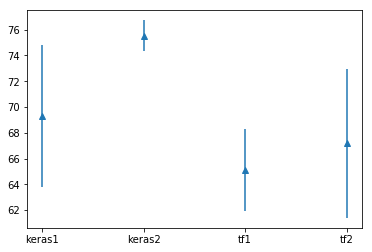

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array([ meanKeras, meanKerasOpt, meanTF, meanTFOpt])
names = np.array(['keras1','keras2','tf1', 'tf2'])
e = np.array([stdKeras, stdsKerasOpt, stdTF, stdTFOpt])

plt.errorbar(names, y, e, linestyle='None', marker='^')

plt.show()

As we can see, the implementations are not statiscally different in all the cases. The strong conclusion is: Keras2 (optimized implementation of Keras) is better than the both implementation of tensorflow. All the rest results are initially inconclusive. It is necessary to make others tests to conclude which one is better than the others (t-test student for example).